In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning models and tools
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, RobustScaler, MinMaxScaler, OrdinalEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score

# Neural network libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [12]:
proteome_tcga = pd.read_csv("TCGA_proteome_data.csv")
proteome_tcga.shape

(1026, 71)

In [13]:
threshold       = 0.9 
columns_with_NA = proteome_tcga.columns[proteome_tcga.isna().mean() > threshold]
proteome_tcga = proteome_tcga.drop(columns = columns_with_NA, axis=1)
proteome_tcga.shape

(1026, 46)

In [14]:
id_columns      = [columns for columns in proteome_tcga.columns if "_id" in columns]
proteome_tcga   = proteome_tcga.drop(columns = id_columns)
proteome_tcga.shape

(1026, 40)

In [15]:
columns_to_drop = ['project', 'updated_datetime', 'treatments_pharmaceutical_treatment_type',
                   'treatments_radiation_treatment_type', 'bcr_patient_barcode', 'alcohol_history',
                   'progression_or_recurrence', 'tumor_grade', 'classification_of_tumor',
                   'last_known_disease_status', 'icd_10_code', 'state', 'days_to_diagnosis', 'days_to_birth', 'year_of_birth', 'morphology']
proteome_tcga = proteome_tcga.drop(columns = columns_to_drop)
proteome_tcga.shape

(1026, 24)

In [16]:
# Replace "not reported" with NaN
proteome_tcga.replace(["Not Reported", "not reported"], np.nan, inplace=True)

# Impute missing values in object columns with mode
object_columns = proteome_tcga.select_dtypes(include='object').columns
proteome_tcga[object_columns] = proteome_tcga[object_columns].fillna(proteome_tcga[object_columns].mode().iloc[0])

# Impute missing values in numerical columns with mean
numerical_columns = proteome_tcga.select_dtypes(include=['float64']).columns
proteome_tcga[numerical_columns] = proteome_tcga[numerical_columns].fillna(proteome_tcga[numerical_columns].mean())

proteome_tcga.isnull().sum()

# Save the cleaned dataset to a new CSV file
proteome_tcga.to_csv("proteome_tcga.csv", index=False)

In [17]:
# Trasnform "ajcc_pathologic_stage" for Invasive and Non-Invasive Cancer Stagging
def map_to_binary_label(stage):
    # Define the stages considered invasive
    invasive_stages = ['Stage IIA', 'Stage IIB', 'Stage IIIA', 'Stage IIIB', 'Stage IV']
    
    # Map to labels: 'Invasive' for invasive stages, 'Non-Invasive' for others
    return 'Invasive' if stage in invasive_stages else 'Non-Invasive'

# Apply the mapping function to create a new target column with labels
proteome_tcga['cancer_stagging'] = proteome_tcga['ajcc_pathologic_stage'].apply(map_to_binary_label)
proteome_tcga = proteome_tcga.drop("ajcc_pathologic_stage", axis=1)

proteome_tcga = proteome_tcga.assign(primary_diagnosis = proteome_tcga['primary_diagnosis'].str.split(', ')).explode('primary_diagnosis').reset_index(drop=True)

tissueOrgan_mappingDict = {
    'Upper lobe, lung': 'Upper lobe',
    'Lower lobe, lung': 'Lower lobe',
    'Lung, NOS': 'NOS',
    'Middle lobe, lung': 'Middle lobe',
    'Overlapping lesion of lung': 'Overlapping lesion',
    'Main bronchus': 'Main bronchus'
}

ethnicity_mappingDict = {
    'not hispanic or latino' : 'not hispanic' ,
    'hispanic or latino'     : 'hispanic'}

race_mappingDict = {'white' : 'white',
                    'black or african american' : 'black',
                    'asian' : 'asian',
                    'american indian or alaska native' : 'american indian'}

proteome_tcga['tissue_or_organ_of_origin']   = proteome_tcga['tissue_or_organ_of_origin'].replace(tissueOrgan_mappingDict)
proteome_tcga['site_of_resection_or_biopsy'] = proteome_tcga['site_of_resection_or_biopsy'].replace(tissueOrgan_mappingDict)
proteome_tcga['ethnicity']                   = proteome_tcga['ethnicity'].replace(ethnicity_mappingDict)
proteome_tcga['race']                        = proteome_tcga['race'].replace(race_mappingDict)

In [22]:
features = proteome_tcga.drop('cancer_stagging', axis=1)
target   = proteome_tcga['cancer_stagging']

In [18]:
def neural_network(input_features):
    optimizer = Adam(learning_rate = 0.001)
    model = Sequential()
    model.add(Dense(units=128, activation='relu', input_dim=input_features.shape[1]))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=2, activation='softmax'))
    model.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def split_data(features, target):
    X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                        stratify     = target,
                                                        test_size    = 0.3,
                                                        random_state = 42
    )
    return X_train, X_test, y_train, y_test

In [19]:
### Select categorical columns
categorical_Columns = ['synchronous_malignancy', 'tissue_or_organ_of_origin', 'prior_malignancy', 'prior_treatment',
                       'ajcc_staging_system_edition', 'ajcc_pathologic_t', 'ajcc_pathologic_n', 'ajcc_pathologic_m',
                       'site_of_resection_or_biopsy', 'race', 'gender', 'ethnicity', 'vital_status', 
                       'treatments_pharmaceutical_treatment_or_therapy','treatments_radiation_treatment_or_therapy'] 

### Select numerical columns
numerical_Columns = ['days_to_last_follow_up', 'age_at_diagnosis', 'year_of_diagnosis','cigarettes_per_day', 
                     'pack_years_smoked', 'age_at_index'] 

In [23]:
numerical_transformer   = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse=False)

PCA_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_Columns),
        ('cat', categorical_transformer, categorical_Columns)
    ])

pca_9 = PCA(n_components=9)
# Define the pipeline with PCA
pca_pipeline_9 = Pipeline(steps=[
    ('preprocessor', PCA_preprocessor),
    ('pca', pca_9)
])

features_pca_9 = pca_pipeline_9.fit_transform(features)

X_train, X_test, y_train, y_test = split_data(features_pca_9, target)
y_train_dummies = pd.get_dummies(y_train)
y_test_dummies  = pd.get_dummies(y_test)
pca_9_model_proteome     = neural_network(X_train)

In [24]:
pca_9_history   = pca_9_model_proteome.fit(X_train, y_train_dummies, validation_data = (X_test, y_test_dummies), epochs = 200, batch_size = 32)

Epoch 1/200


42/42 [==============================] - 2s 9ms/step - loss: 0.6216 - accuracy: 0.6687 - val_loss: 0.5152 - val_accuracy: 0.7853
Epoch 2/200
42/42 [==============================] - 0s 3ms/step - loss: 0.4800 - accuracy: 0.7853 - val_loss: 0.4406 - val_accuracy: 0.8063
Epoch 3/200
42/42 [==============================] - 0s 3ms/step - loss: 0.4366 - accuracy: 0.8003 - val_loss: 0.4326 - val_accuracy: 0.8080
Epoch 4/200
42/42 [==============================] - 0s 3ms/step - loss: 0.4184 - accuracy: 0.8040 - val_loss: 0.4128 - val_accuracy: 0.8168
Epoch 5/200
42/42 [==============================] - 0s 3ms/step - loss: 0.3956 - accuracy: 0.8212 - val_loss: 0.4202 - val_accuracy: 0.8185
Epoch 6/200
42/42 [==============================] - 0s 4ms/step - loss: 0.3809 - accuracy: 0.8182 - val_loss: 0.4124 - val_accuracy: 0.8185
Epoch 7/200
42/42 [==============================] - 0s 4ms/step - loss: 0.3661 - accuracy: 0.8325 - val_loss: 0.4032 - val_accuracy: 0.8185
Epoch 8/200

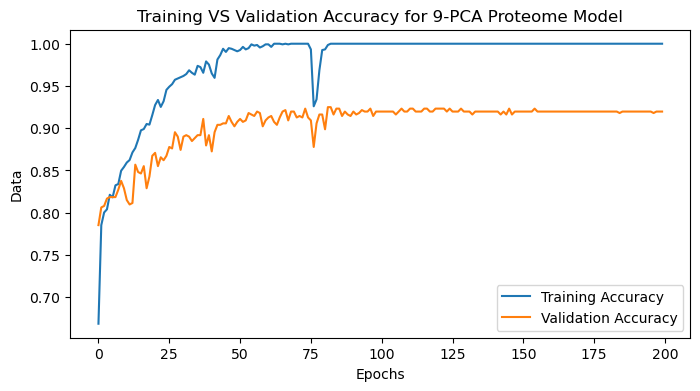

In [25]:
plt.figure(figsize = (8,4))
plt.plot(pca_9_history.history["accuracy"], label = "Training Accuracy")
plt.plot(pca_9_history.history["val_accuracy"], label = "Validation Accuracy")
plt.title("Training VS Validation Accuracy for 9-PCA Proteome Model", fontsize = 12)
plt.xlabel("Epochs")
plt.ylabel("Data")
plt.legend()
plt.show()

In [26]:
pca_9_proteome_test  = pca_9_model_proteome.predict(X_test)
pca_9_proteome_train = pca_9_model_proteome.predict(X_train)

42/42 [==============================] - 0s 1ms/step


In [27]:
class_labels     = ['Invasive', 'Non-Invasive']
pca_9_proteome_test  = [class_labels[label] for label in np.argmax(pca_9_proteome_test, axis=1)]
pca_9_proteome_train = [class_labels[label] for label in np.argmax(pca_9_proteome_train, axis=1)]
print(classification_report(y_test, pca_9_proteome_test))

              precision    recall  f1-score   support

    Invasive       0.94      0.88      0.91       267
Non-Invasive       0.90      0.95      0.93       306

    accuracy                           0.92       573
   macro avg       0.92      0.92      0.92       573
weighted avg       0.92      0.92      0.92       573



<Figure size 800x400 with 0 Axes>

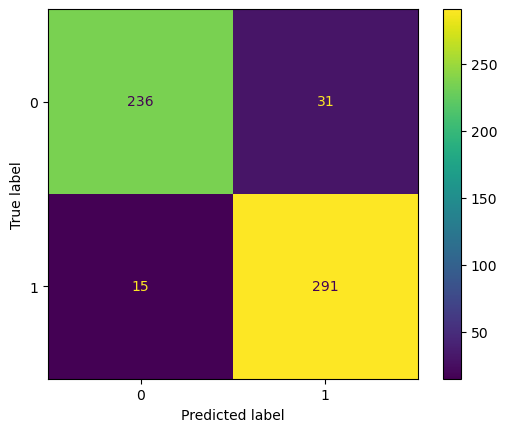

In [29]:
pca_9_proteome_cm     = confusion_matrix(y_test, pca_9_proteome_test)
pca_9_proteome_cm_dip = ConfusionMatrixDisplay(confusion_matrix = pca_9_proteome_cm,
                                       display_labels=['0','1'])
plt.figure(figsize = (8,4))
pca_9_proteome_cm_dip.plot()
plt.show()